# ANLI with LLM

You have to implement in this notebook a better ANLI classifier using an LLM.
This classifier must be implemented using DSPy.


In [ ]:
# Configure the DSPy environment with the language model - for grok the parameters must be:
# env variable should be in os.environ['XAI_API_KEY']
# "xai/grok-3-mini"
import os
import dspy

os.environ['XAI_API_KEY'] = 'YOUR-API-KEY-HERE'  # Set your API key here

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
# for ollama 
# lm = dspy.LM('ollama_chat/devstral', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=lm)

## Defining classifiers

In [48]:
from typing import Literal
from sentence_transformers import SentenceTransformer, CrossEncoder
import numpy as np

## Implement the DSPy classifier program.
similarity_model = SentenceTransformer("all-MiniLM-L6-v2")

class NLISignature(dspy.Signature):
    """Natural Language Inference task: Given a premise and hypothesis, classify the relationship and provide explanation."""
    premise = dspy.InputField(desc="The premise statement")
    hypothesis = dspy.InputField(desc="The hypothesis statement")
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis")
    label = dspy.OutputField(desc="Classification: entailment, contradiction, or neutral")

class NLIExplanationSignature(dspy.Signature):
    """Generate explanation for Natural Language Inference."""
    premise = dspy.InputField(desc="The premise statement")
    hypothesis = dspy.InputField(desc="The hypothesis statement")
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis")

class NLILabelSignature(dspy.Signature):
    """Classify Natural Language Inference given explanation."""
    premise = dspy.InputField(desc="The premise statement")
    hypothesis = dspy.InputField(desc="The hypothesis statement")
    explanation = dspy.InputField(desc="Explanation of the relationship")
    label = dspy.OutputField(desc="Classification: entailment, contradiction, or neutral")

class JointNLIClassifier(dspy.Module):
    """Joint prompt approach: generate explanation and label together."""
    
    def __init__(self):
        super().__init__()
        self.classifier = dspy.ChainOfThought(NLISignature)
    
    def forward(self, premise, hypothesis):
        result = self.classifier(premise=premise, hypothesis=hypothesis)
        return dspy.Prediction(
            explanation=result.explanation,
            label=result.label
        )

class PipelineNLIClassifier(dspy.Module):
    """Pipeline approach: generate explanation first, then label."""
    
    def __init__(self):
        super().__init__()
        self.explainer = dspy.ChainOfThought(NLIExplanationSignature)
        self.classifier = dspy.ChainOfThought(NLILabelSignature)
    
    def forward(self, premise, hypothesis):
        # First generate explanation
        explanation_result = self.explainer(premise=premise, hypothesis=hypothesis)
        
        # Then classify using the explanation
        label_result = self.classifier(
            premise=premise, 
            hypothesis=hypothesis, 
            explanation=explanation_result.explanation
        )
        
        return dspy.Prediction(
            explanation=explanation_result.explanation,
            label=label_result.label
        )

class RefinedNLIClassifier(dspy.Module):
    """Refined classifier that uses similarity metrics to improve explanations."""
    
    def __init__(self, base_classifier, similarity_threshold=0.7, max_attempts=3, use_human_reason=True):
        super().__init__()
        self.base_classifier = base_classifier
        self.similarity_threshold = similarity_threshold
        self.max_attempts = max_attempts
        self.use_human_reason = use_human_reason
        # Initialize the refiner module
        self.refiner = dspy.ChainOfThought(NLISignature)
    
    def calculate_similarity(self, premise, hypothesis, explanation):
        """Calculate similarity between explanation and (premise, hypothesis)."""
        premise_hyp_text = f"{premise} {hypothesis}"
        embeddings = similarity_model.encode([premise_hyp_text, explanation])
        similarity = similarity_model.similarity(embeddings, embeddings)[0][1].item()
        return similarity
    
    def calculate_similarity_to_human(self, predicted_explanation, human_reason):
        """Calculate similarity between predicted explanation and human reason."""
        if not human_reason:
            return 0.0
        embeddings = similarity_model.encode([predicted_explanation, human_reason])
        similarity = similarity_model.similarity(embeddings, embeddings)[0][1].item()
        return similarity
    
    def get_combined_score(self, explanation, premise, hypothesis, human_reason):
        """Calculate combined similarity score."""
        premise_hyp_similarity = self.calculate_similarity(premise, hypothesis, explanation)
        
        if self.use_human_reason and human_reason:
            human_similarity = self.calculate_similarity_to_human(explanation, human_reason)
            # Weighted combination: 60% human similarity + 40% premise-hypothesis similarity
            return 0.6 * human_similarity + 0.4 * premise_hyp_similarity
        else:
            return premise_hyp_similarity
    
    def forward(self, premise, hypothesis, human_reason=None):
        # Get initial prediction
        initial_pred = self.base_classifier(premise=premise, hypothesis=hypothesis)
        
        current_explanation = initial_pred.explanation
        current_label = initial_pred.label
        
        # Calculate initial score
        initial_score = self.get_combined_score(current_explanation, premise, hypothesis, human_reason)
        current_score = initial_score
        
        attempt = 0
        refinement_history = []
        was_refined = False
        
        # Try refinement if score is below threshold
        while attempt < self.max_attempts and current_score < self.similarity_threshold:
            attempt += 1
            
            try:
                # Try to get a better explanation
                refined_pred = self.refiner(
                    premise=premise,
                    hypothesis=hypothesis
                )
                
                # Calculate new score
                new_score = self.get_combined_score(refined_pred.explanation, premise, hypothesis, human_reason)
                
                # Store refinement attempt
                refinement_history.append({
                    'attempt': attempt,
                    'explanation': refined_pred.explanation,
                    'label': refined_pred.label,
                    'score': new_score,
                    'premise_hyp_similarity': self.calculate_similarity(premise, hypothesis, refined_pred.explanation),
                    'human_similarity': self.calculate_similarity_to_human(refined_pred.explanation, human_reason) if human_reason else None
                })
                
                # Use the better explanation if it improves the score
                if new_score > current_score:
                    current_explanation = refined_pred.explanation
                    current_label = refined_pred.label
                    current_score = new_score
                    was_refined = True
                    
                    if current_score >= self.similarity_threshold:
                        break

            except Exception as e:
                print(f"  Refinement attempt {attempt} failed: {e}")
                refinement_history.append({
                    'attempt': attempt,
                    'error': str(e),
                    'score': None
                })
                continue
        
        # Calculate final similarities for tracking
        final_premise_hyp_similarity = self.calculate_similarity(premise, hypothesis, current_explanation)
        final_human_similarity = self.calculate_similarity_to_human(current_explanation, human_reason) if human_reason else None
        
        return dspy.Prediction(
            explanation=current_explanation,
            label=current_label,
            similarity_score=final_premise_hyp_similarity,
            human_similarity_score=final_human_similarity,
            combined_score=current_score,
            was_refined=was_refined,
            refinement_attempts=attempt,
            initial_score=initial_score,
            refinement_history=refinement_history,
            threshold_reached=current_score >= self.similarity_threshold
        )
            
            
# Initialize classifiers
joint_classifier = JointNLIClassifier()
pipeline_classifier = PipelineNLIClassifier()
refined_joint_classifier = RefinedNLIClassifier(joint_classifier)
refined_pipeline_classifier = RefinedNLIClassifier(pipeline_classifier)


### Evaluation functions for model labeling and their explanations

In [67]:
def evaluate_explanation_quality(premise, hypothesis, predicted_explanation, human_reason=None):
    """Evaluate the quality of predicted explanation using similarity metrics."""
    premise_hyp_text = f"{premise} {hypothesis}"
    
    similarities = {}
    
    # Similarity between predicted explanation and (premise, hypothesis)
    embeddings_pred = similarity_model.encode([premise_hyp_text, predicted_explanation])
    similarities['pred_vs_premise_hyp'] = similarity_model.similarity(
        embeddings_pred, embeddings_pred
    )[0][1].item()
    
    if human_reason:
        # Similarity between predicted explanation and human reason
        embeddings_human = similarity_model.encode([predicted_explanation, human_reason])
        similarities['pred_vs_human'] = similarity_model.similarity(
            embeddings_human, embeddings_human
        )[0][1].item()
        
        # Similarity between (premise, hypothesis) and human reason
        embeddings_baseline = similarity_model.encode([premise_hyp_text, human_reason])
        similarities['premise_hyp_vs_human'] = similarity_model.similarity(
            embeddings_baseline, embeddings_baseline
        )[0][1].item()
    
    return similarities

def normalize_label(label):
    """Normalize label to standard format."""
    if isinstance(label, str):
        label = label.lower().strip()
        if label in ['entailment', 'entails', 'e']:
            return 'entailment'
        elif label in ['contradiction', 'contradicts', 'c']:
            return 'contradiction'
        elif label in ['neutral', 'n']:
            return 'neutral'
    elif isinstance(label, int):
        if label == 0:
            return 'entailment'
        elif label == 1:
            return 'neutral'
        elif label == 2:
            return 'contradiction'
    return str(label)

In [39]:
import pandas as pd
from tqdm import tqdm
import json

def evaluate_model(model, dataset_split, model_name, max_samples=300):
    """Evaluate a model on a dataset split - returns only results without computing metrics."""
    results = []
    predictions = []
    ground_truth = []
    explanation_qualities = []
    
    print(f"Evaluating {model_name} on {max_samples} samples...")
    
    for i, sample in enumerate(tqdm(dataset_split, desc=f"Processing {model_name}")):
        if i >= max_samples:
            break
        try:
            if hasattr(model, 'base_classifier'):  # RefinedNLIClassifier
                pred = model(
                    premise=sample['premise'],
                    hypothesis=sample['hypothesis'],
                    human_reason=sample.get('reason')
                )
            else:  #JointNLIClassifier or PipelineNLIClassifier
                pred = model(
                    premise=sample['premise'],
                    hypothesis=sample['hypothesis']
                )
            
            pred_label = normalize_label(pred.label)
            true_label = normalize_label(sample['label'])
            
            explanation_quality = evaluate_explanation_quality(
                sample['premise'],
                sample['hypothesis'],
                pred.explanation,
                sample.get('reason')
            )
            
            results.append({
                'premise': sample['premise'],
                'hypothesis': sample['hypothesis'],
                'true_label': true_label,
                'pred_label': pred_label,
                'predicted_explanation': pred.explanation,
                'human_reason': sample.get('reason'),
                'explanation_quality': explanation_quality,
                'similarity_score': getattr(pred, 'similarity_score', None),
                'was_refined': getattr(pred, 'was_refined', False)
            })
            
            predictions.append(pred_label)
            ground_truth.append(true_label)
            explanation_qualities.append(explanation_quality)
            
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    return {
        'model_name': model_name,
        'results': results,
        'predictions': predictions,
        'ground_truth': ground_truth,
        'explanation_qualities': explanation_qualities
    }

## Running evaluation

Make sure you load the ANLI dataset before running the following cells.

In [28]:
dev_r3_data = dataset['dev_r3']

In [37]:
dev_r3_data

Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
    num_rows: 1200
})

### Joint NLI Classifier

In [ ]:
print("\n" + "="*60)
print("EVALUATING JOINT CLASSIFIER")
print("="*60)
joint_results = evaluate_model(joint_classifier, dev_r3_data, "Joint NLI Classifier")
joint_results

### Pipeline NLI Classifier

In [45]:
print("\n" + "="*60)
print("EVALUATING PIPELINE CLASSIFIER")
print("="*60)
pipeline_results = evaluate_model(pipeline_classifier, dev_r3_data, "Pipeline NLI Classifier")
pipeline_results


EVALUATING PIPELINE CLASSIFIER
Evaluating Pipeline NLI Classifier on 300 samples...


Processing Pipeline NLI Classifier:  25%|██▌       | 300/1200 [45:56<2:17:48,  9.19s/it]


{'model_name': 'Pipeline NLI Classifier',
 'results': [{'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.',
   'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.',
   'true_label': 0,
   'pred_label': 'entailment',
   'predicted_explanation': 'The premise and hypothesis are related through the implication of privacy in the description of the business relocation. The phrase "far away from the prying eyes" in the premise indicates an effort to shield the activity from public view, which aligns with and supports the hypothesis that the decision was for privacy reasons. This creates an entailment relationship, where the premise provides direct evidence for the hyp

### Refined Joint NLI Classifier

In [49]:
print("\n" + "="*60)
print("EVALUATING REFINED JOINT CLASSIFIER")
print("="*60)
refined_joint_results = evaluate_model(
    refined_joint_classifier, 
    dev_r3_data, 
    "Refined Joint NLI Classifier"
)
refined_joint_results


EVALUATING REFINED JOINT CLASSIFIER
Evaluating Refined Joint NLI Classifier on 300 samples...


Processing Refined Joint NLI Classifier:  25%|██▌       | 300/1200 [09:49<29:29,  1.97s/it]  


{'model_name': 'Refined Joint NLI Classifier',
 'results': [{'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.',
   'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.',
   'true_label': 0,
   'pred_label': 'entailment',
   'predicted_explanation': 'The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation. This directly supports the hypothesis that the decision was made for privacy reasons, as the language in the premise suggests an intentional effort to enhance seclusion. Therefore, the relationship is one of entailment

### Refined Pipeline NLI Classifier

In [50]:
print("\n" + "="*60)
print("EVALUATING REFINED JOINT CLASSIFIER")
print("="*60)
refined_pipeline_results = evaluate_model(
    refined_pipeline_classifier, 
    dev_r3_data, 
    "Refined Pipeline NLI Classifier"
)
refined_pipeline_results


EVALUATING REFINED JOINT CLASSIFIER
Evaluating Refined Pipeline NLI Classifier on 300 samples...


Processing Refined Pipeline NLI Classifier:  25%|██▌       | 300/1200 [12:27<37:21,  2.49s/it]   


{'model_name': 'Refined Pipeline NLI Classifier',
 'results': [{'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.',
   'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.',
   'true_label': 0,
   'pred_label': 'entailment',
   'predicted_explanation': 'The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation. This directly supports the hypothesis that the decision was made for privacy reasons, as the language in the premise suggests an intentional effort to enhance seclusion. Therefore, the relationship is one of entailm

## Load ANLI dataset

In [41]:
from datasets import load_dataset

dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [42]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [43]:
import evaluate
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

## Your Turn

Compute the classification metrics on the baseline LLM model on each test section of the ANLI dataset for samples that have a non-empty 'reason' field.

You also must show a comparison between the DeBERTa baseline model and this LLM baseline model. The comparison metric should compute the agreement between the two models:
* On how many samples they are both correct [Correct]
* On how many samples Model1 is correct and Model2 is incorrect [Correct1]
* On how many samples Model1 is incorrect and Model2 is correct [Correct2]
* On how many samples both are incorrect [Incorrect]

RUNNING COMPREHENSIVE ANALYSIS
Results loaded successfully:
  Joint: 300 predictions
  Pipeline: 300 predictions
  Refined Joint: 300 predictions
  Refined Pipeline: 300 predictions

CLASSIFICATION PERFORMANCE COMPARISON

Processing Joint...
  Sample predictions: ['entailment', 'neutral', 'entailment']
  Sample ground truth: [0, 0, 0]
  Computed metrics: {'accuracy': 0.6933333333333334, 'f1': 0.6976957604861698, 'precision': 0.7304938756443863, 'recall': 0.6933333333333334}

Processing Pipeline...
  Sample predictions: ['entailment', 'entailment', 'entailment']
  Sample ground truth: [0, 0, 0]
  Computed metrics: {'accuracy': 0.7133333333333334, 'f1': 0.7163882084458681, 'precision': 0.7314697815652855, 'recall': 0.7133333333333334}

Processing Refined Joint...
  Sample predictions: ['entailment', 'neutral', 'entailment']
  Sample ground truth: [0, 0, 0]
  Computed metrics: {'accuracy': 0.6933333333333334, 'f1': 0.6976957604861698, 'precision': 0.7304938756443863, 'recall': 0.693333333

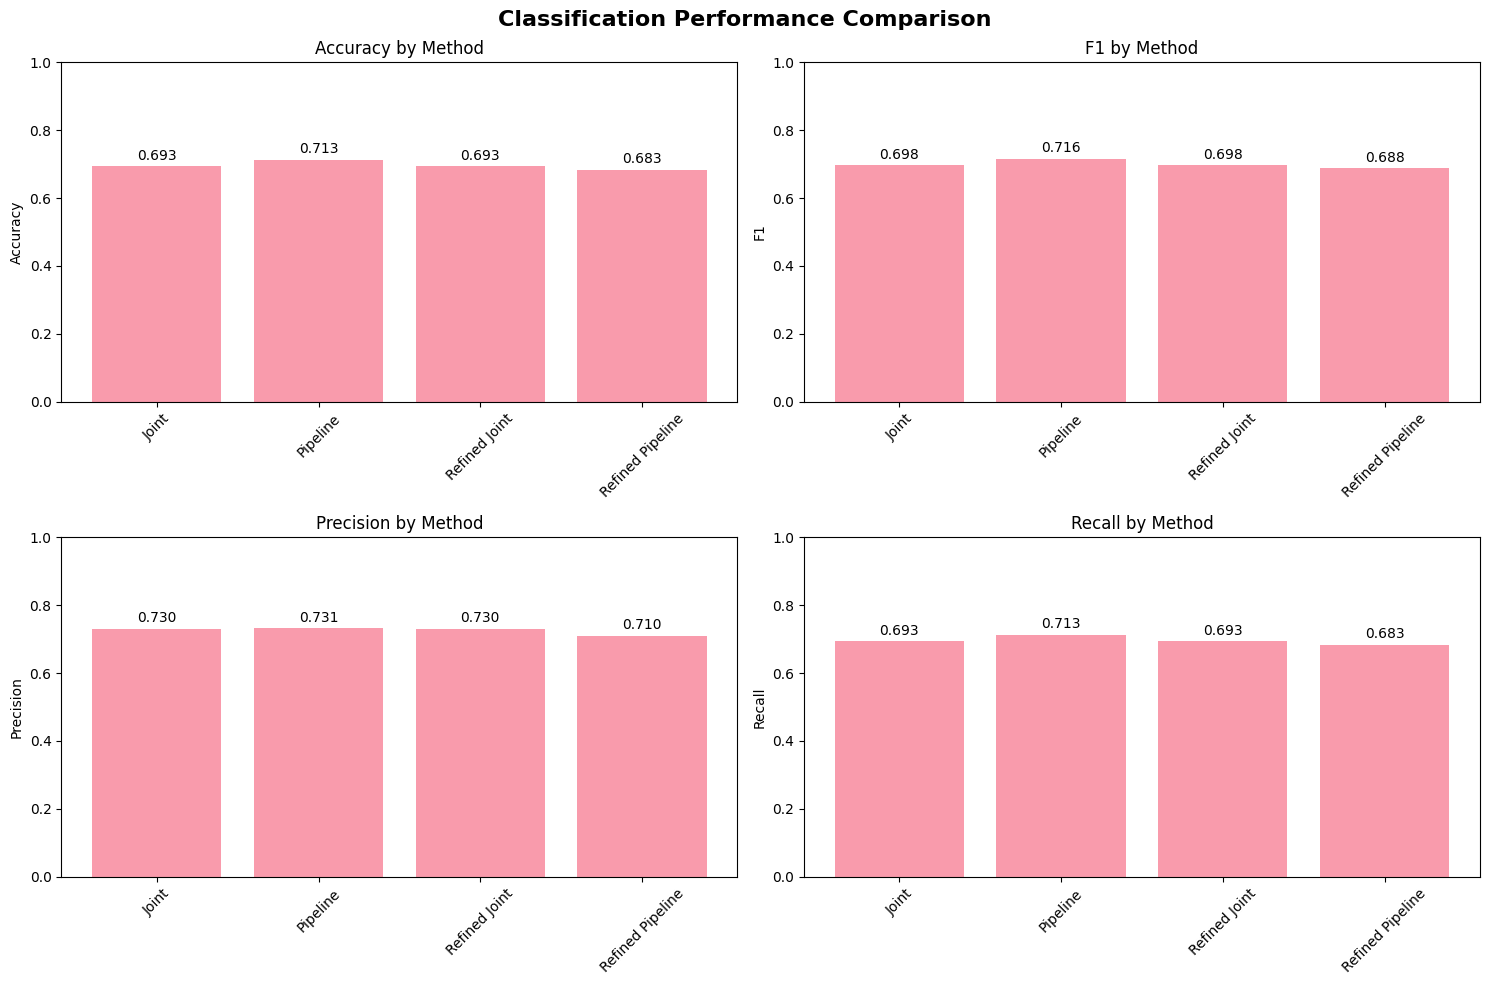


CONFUSION MATRICES COMPARISON


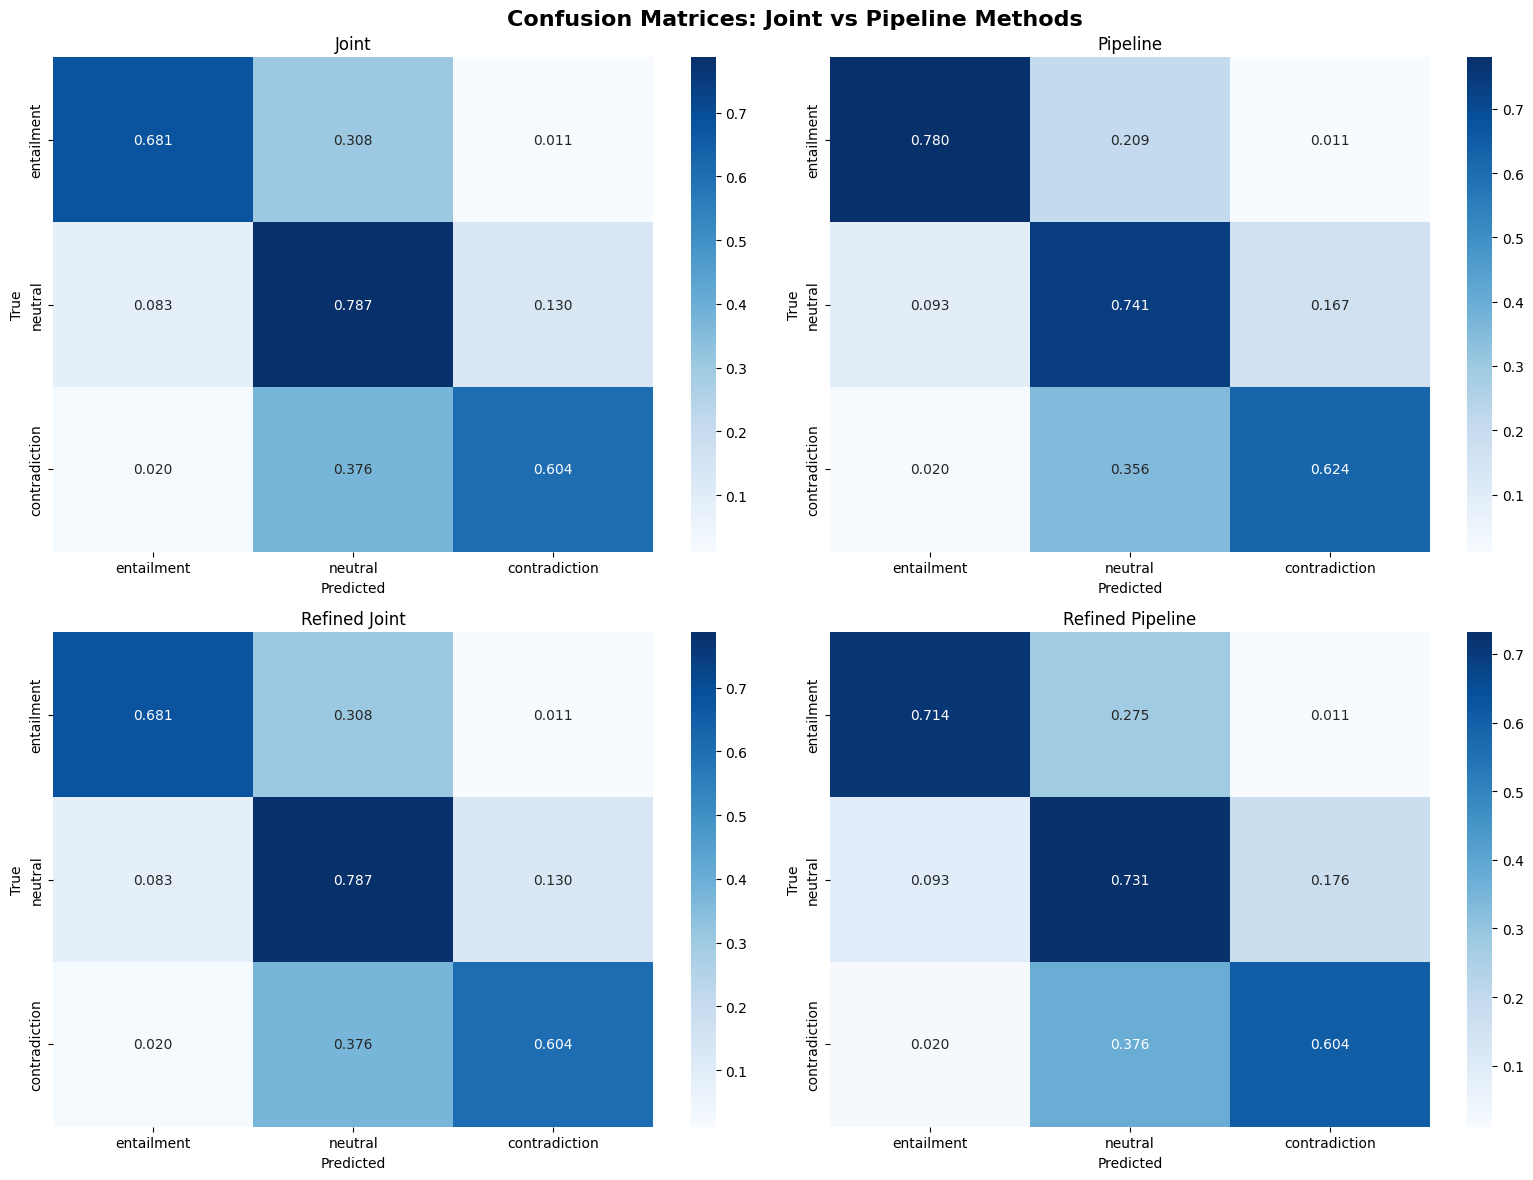


MODEL AGREEMENT ANALYSIS: JOINT VS PIPELINE

Joint vs Pipeline Agreement Analysis (Total samples: 300):
Both Correct: 191 (63.67%)
Joint Only Correct: 17 (5.67%)
Pipeline Only Correct: 23 (7.67%)
Both Incorrect: 69 (23.00%)


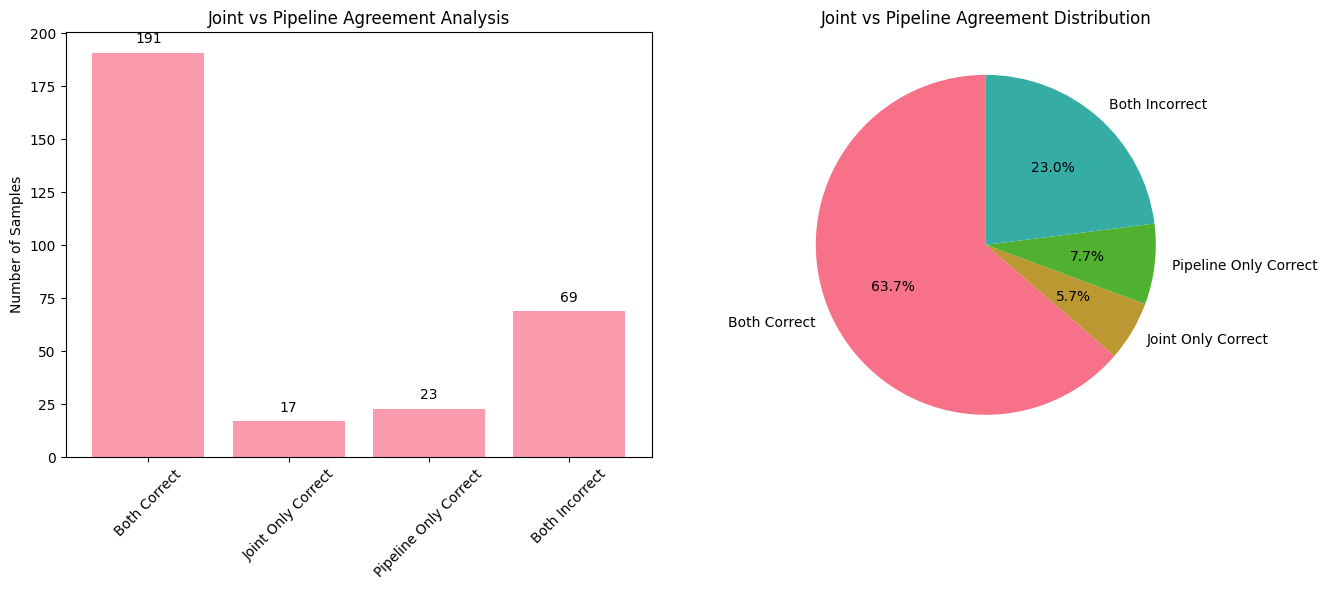


REFINED VS BASE COMPARISON

Joint vs Refined Joint Agreement Analysis (Total samples: 300):
Both Correct: 208 (69.33%)
Joint Only Correct: 0 (0.00%)
Refined Only Correct: 0 (0.00%)
Both Incorrect: 92 (30.67%)


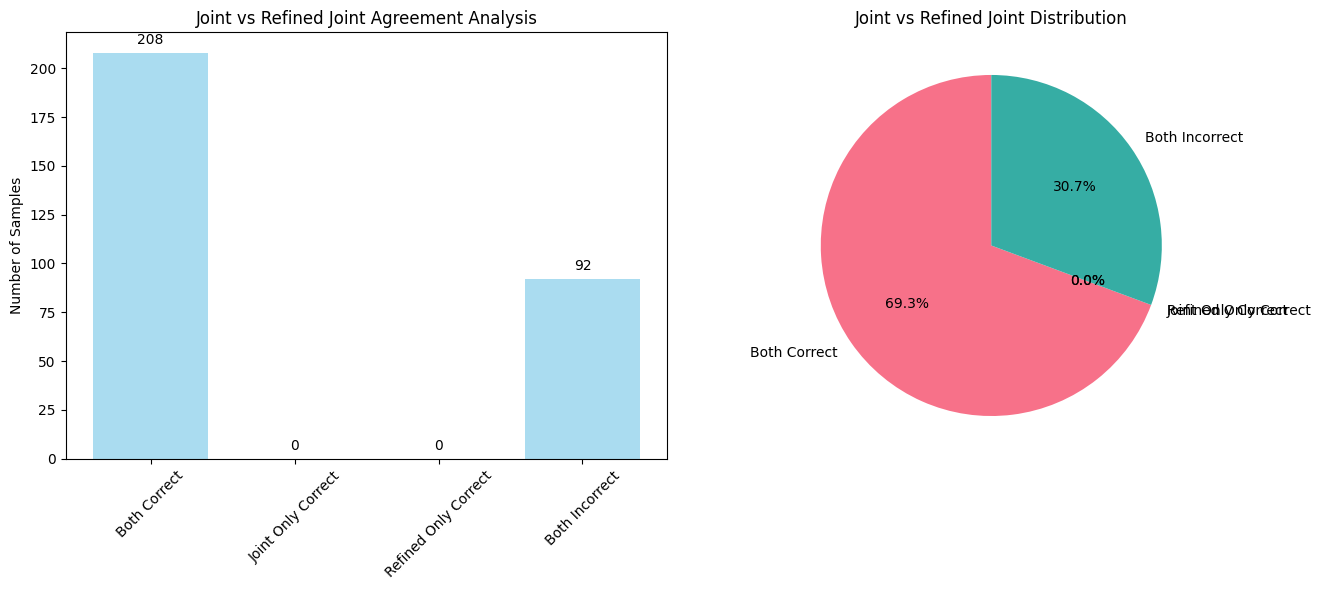


Pipeline vs Refined Pipeline Agreement Analysis (Total samples: 300):
Both Correct: 201 (67.00%)
Pipeline Only Correct: 13 (4.33%)
Refined Only Correct: 4 (1.33%)
Both Incorrect: 82 (27.33%)


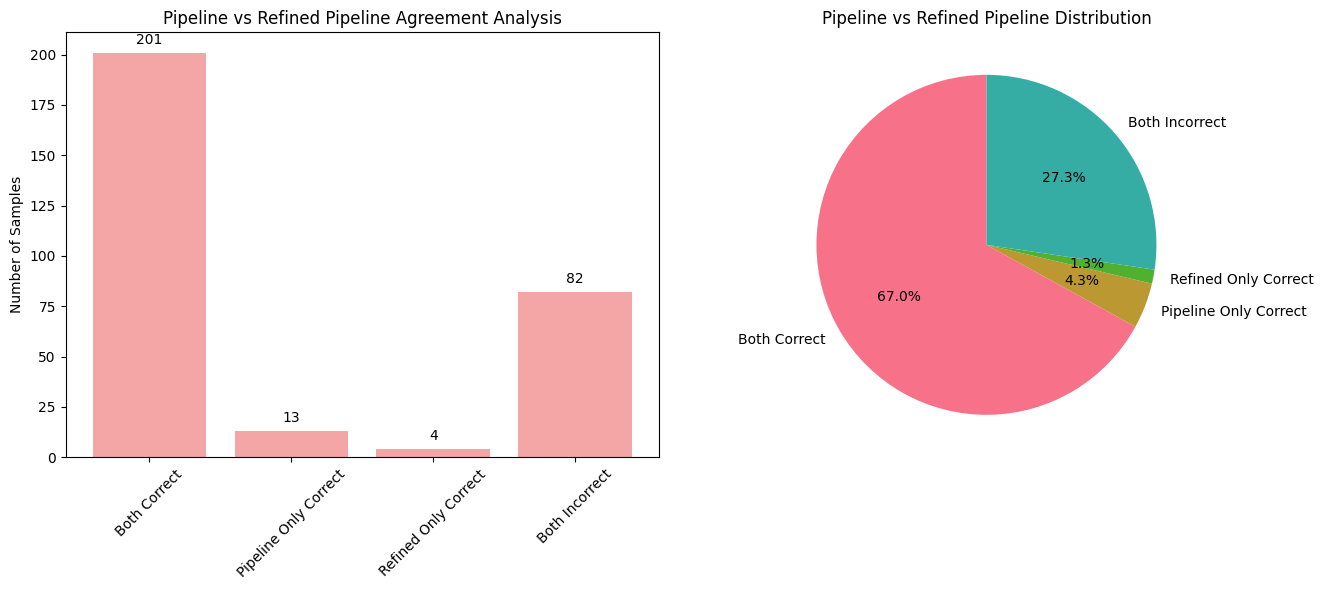


EXPLANATION QUALITY ANALYSIS

Explanation Quality Metrics:
                  avg_pred_vs_premise_hyp  avg_pred_vs_human
method                                                      
Joint                              0.4606             0.4904
Pipeline                           0.4728             0.4932
Refined Joint                      0.4606             0.4904
Refined Pipeline                   0.5174             0.5223


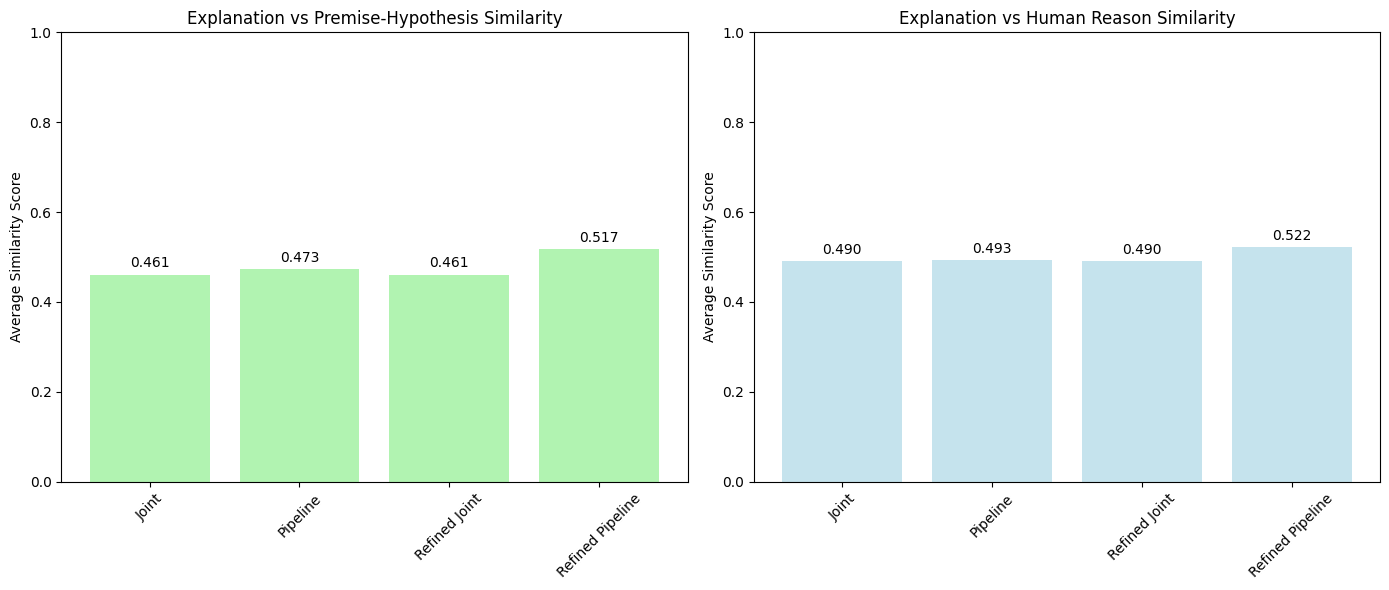


FINAL SUMMARY

Final Performance Summary:
                  accuracy      f1  precision  recall  num_samples
method                                                            
Joint               0.6933  0.6977     0.7305  0.6933          300
Pipeline            0.7133  0.7164     0.7315  0.7133          300
Refined Joint       0.6933  0.6977     0.7305  0.6933          300
Refined Pipeline    0.6833  0.6879     0.7099  0.6833          300

Best performing model: Pipeline with accuracy: 0.7133

Explanation Quality Summary:
                  avg_pred_vs_premise_hyp  avg_pred_vs_human
method                                                      
Joint                              0.4606             0.4904
Pipeline                           0.4728             0.4932
Refined Joint                      0.4606             0.4904
Refined Pipeline                   0.5174             0.5223

Joint vs Pipeline Agreement:
  Both Correct: 191
  Joint Only Correct: 17
  Pipeline Only Correct: 23
 

In [70]:
# Complete analysis and comparison code
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def create_label_mapping():
    """Create mapping between string labels and numeric labels."""
    label_to_id = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    id_to_label = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
    return label_to_id, id_to_label

def normalize_and_convert_labels(labels, target_format='string'):
    """Normalize labels and convert to target format (string or numeric)."""
    normalized = []
    
    for label in labels:
        if isinstance(label, int):
            # Convert integer to string first
            if label == 0:
                norm_label = 'entailment'
            elif label == 1:
                norm_label = 'neutral' 
            elif label == 2:
                norm_label = 'contradiction'
            else:
                norm_label = str(label)
        elif isinstance(label, str):
            # Normalize string labels
            label = label.lower().strip()
            if label in ['entailment', 'entails', 'e']:
                norm_label = 'entailment'
            elif label in ['contradiction', 'contradicts', 'c']:
                norm_label = 'contradiction'
            elif label in ['neutral', 'n']:
                norm_label = 'neutral'
            else:
                norm_label = label
        else:
            norm_label = str(label)
        
        if target_format == 'numeric':
            # Convert to numeric
            if norm_label == 'entailment':
                normalized.append(0)
            elif norm_label == 'neutral':
                normalized.append(1)
            elif norm_label == 'contradiction':
                normalized.append(2)
            else:
                normalized.append(-1)
        else:
            normalized.append(norm_label)
    
    return normalized

def compute_classification_metrics_safe(predictions, references):
    """Compute classification metrics with proper label handling."""
    # Normalize both to strings first, then convert to numeric
    norm_predictions = normalize_and_convert_labels(predictions, 'string')
    norm_references = normalize_and_convert_labels(references, 'string')
    
    # Convert to numeric
    numeric_predictions = normalize_and_convert_labels(norm_predictions, 'numeric')
    numeric_references = normalize_and_convert_labels(norm_references, 'numeric')
    
    # Filter out invalid labels
    valid_indices = [i for i, (p, r) in enumerate(zip(numeric_predictions, numeric_references)) if p != -1 and r != -1]
    
    if not valid_indices:
        return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}
    
    filtered_predictions = [numeric_predictions[i] for i in valid_indices]
    filtered_references = [numeric_references[i] for i in valid_indices]
    
    metrics = {}
    
    try:
        metrics['accuracy'] = accuracy.compute(predictions=filtered_predictions, references=filtered_references)['accuracy']
        metrics['f1'] = f1.compute(predictions=filtered_predictions, references=filtered_references, average='weighted')['f1']
        metrics['precision'] = precision.compute(predictions=filtered_predictions, references=filtered_references, average='weighted')['precision']
        metrics['recall'] = recall.compute(predictions=filtered_predictions, references=filtered_references, average='weighted')['recall']
    except Exception as e:
        print(f"Error computing metrics: {e}")
        return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}
    
    return metrics

def analyze_and_compare_methods(joint_res, pipeline_res, refined_joint_res, refined_pipeline_res):
    """Comprehensive analysis and comparison of Joint vs Pipeline methods."""
    
    # Create label mapping
    label_to_id, id_to_label = create_label_mapping()
    
    # Extract results - pass them directly instead of using globals()
    methods_data = {
        'Joint': joint_res,
        'Pipeline': pipeline_res,
        'Refined Joint': refined_joint_res,
        'Refined Pipeline': refined_pipeline_res
    }
    
    print("Results loaded successfully:")
    for name, data in methods_data.items():
        if data and 'predictions' in data:
            print(f"  {name}: {len(data['predictions'])} predictions")
        else:
            print(f"  {name}: NO DATA")
    
    # 1. CLASSIFICATION PERFORMANCE COMPARISON
    print("\n" + "="*80)
    print("CLASSIFICATION PERFORMANCE COMPARISON")
    print("="*80)
    
    performance_metrics = []
    
    for method_name, results in methods_data.items():
        print(f"\nProcessing {method_name}...")
        
        if not results or not results.get('predictions') or not results.get('ground_truth'):
            print(f"  Skipping {method_name}: empty predictions or ground truth")
            continue
            
        print(f"  Sample predictions: {results['predictions'][:3]}")
        print(f"  Sample ground truth: {results['ground_truth'][:3]}")
        
        # Calculate metrics using the safe function
        metrics = compute_classification_metrics_safe(results['predictions'], results['ground_truth'])
        
        print(f"  Computed metrics: {metrics}")
        
        # Add method name
        metrics['method'] = method_name
        metrics['num_samples'] = len(results['predictions'])
        
        performance_metrics.append(metrics)
    
    if not performance_metrics:
        print("No valid performance metrics computed")
        return None, None, None
    
    # Create performance DataFrame
    perf_df = pd.DataFrame(performance_metrics)
    perf_df = perf_df.set_index('method')
    
    print("\nPerformance Metrics Summary:")
    print(perf_df.round(4))
    
    # Plot performance metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Classification Performance Comparison', fontsize=16, fontweight='bold')
    
    metrics_to_plot = ['accuracy', 'f1', 'precision', 'recall']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx//2, idx%2]
        if metric in perf_df.columns and len(perf_df) > 0:
            bars = ax.bar(perf_df.index, perf_df[metric], alpha=0.7)
            ax.set_title(f'{metric.capitalize()} by Method')
            ax.set_ylabel(metric.capitalize())
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0, 1.0)  # Set y-axis to 0-1 range
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.3f}', ha='center', va='bottom')
        else:
            ax.text(0.5, 0.5, f'No data for {metric}', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # 2. CONFUSION MATRICES COMPARISON
    print("\n" + "="*80)
    print("CONFUSION MATRICES COMPARISON")
    print("="*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Confusion Matrices: Joint vs Pipeline Methods', fontsize=16, fontweight='bold')
    
    labels = ['entailment', 'neutral', 'contradiction']
    
    for idx, (method_name, results) in enumerate(methods_data.items()):
        ax = axes[idx//2, idx%2]
        
        if results and results.get('predictions') and results.get('ground_truth'):
            try:
                # Normalize labels for confusion matrix
                norm_pred = normalize_and_convert_labels(results['predictions'], 'string')
                norm_true = normalize_and_convert_labels(results['ground_truth'], 'string')
                
                cm = confusion_matrix(norm_true, norm_pred, labels=labels)
                
                # Normalize confusion matrix
                cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)
                
                sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                           xticklabels=labels, yticklabels=labels, ax=ax)
                ax.set_title(f'{method_name}')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('True')
            except Exception as e:
                print(f"Error creating confusion matrix for {method_name}: {e}")
                ax.text(0.5, 0.5, f'Error: {e}', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, f'No data for {method_name}', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # 3. MODEL AGREEMENT ANALYSIS: JOINT VS PIPELINE
    print("\n" + "="*80)
    print("MODEL AGREEMENT ANALYSIS: JOINT VS PIPELINE")
    print("="*80)
    
    # Compare base methods (without refinement)
    if (joint_res and joint_res.get('predictions') and 
        pipeline_res and pipeline_res.get('predictions') and
        len(joint_res['predictions']) == len(pipeline_res['predictions']) == len(joint_res['ground_truth'])):
        
        # Normalize all labels for comparison
        joint_preds = normalize_and_convert_labels(joint_res['predictions'], 'string')
        pipeline_preds = normalize_and_convert_labels(pipeline_res['predictions'], 'string')
        ground_truth = normalize_and_convert_labels(joint_res['ground_truth'], 'string')
        
        # Agreement analysis
        both_correct = sum(1 for j, p, t in zip(joint_preds, pipeline_preds, ground_truth) 
                          if j == t and p == t)
        joint_only_correct = sum(1 for j, p, t in zip(joint_preds, pipeline_preds, ground_truth) 
                               if j == t and p != t)
        pipeline_only_correct = sum(1 for j, p, t in zip(joint_preds, pipeline_preds, ground_truth) 
                                  if j != t and p == t)
        both_incorrect = sum(1 for j, p, t in zip(joint_preds, pipeline_preds, ground_truth) 
                           if j != t and p != t)
        
        total = len(ground_truth)
        
        agreement_data = {
            'Both Correct': both_correct,
            'Joint Only Correct': joint_only_correct,
            'Pipeline Only Correct': pipeline_only_correct,
            'Both Incorrect': both_incorrect
        }
        
        print(f"\nJoint vs Pipeline Agreement Analysis (Total samples: {total}):")
        for category, count in agreement_data.items():
            percentage = (count / total) * 100
            print(f"{category}: {count} ({percentage:.2f}%)")
        
        # Plot agreement analysis
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Bar plot
        bars = ax1.bar(agreement_data.keys(), agreement_data.values(), alpha=0.7)
        ax1.set_title('Joint vs Pipeline Agreement Analysis')
        ax1.set_ylabel('Number of Samples')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + total*0.01, 
                    f'{int(height)}', ha='center', va='bottom')
        
        # Pie chart
        ax2.pie(agreement_data.values(), labels=agreement_data.keys(), autopct='%1.1f%%', startangle=90)
        ax2.set_title('Joint vs Pipeline Agreement Distribution')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("Cannot perform agreement analysis - data mismatch or missing")
        agreement_data = None
    
    # 4. REFINED VS BASE COMPARISON
    print("\n" + "="*80)
    print("REFINED VS BASE COMPARISON")
    print("="*80)
    
    # Compare Joint vs Refined Joint
    if (joint_res and joint_res.get('predictions') and 
        refined_joint_res and refined_joint_res.get('predictions') and
        len(joint_res['predictions']) == len(refined_joint_res['predictions'])):
        
        joint_preds = normalize_and_convert_labels(joint_res['predictions'], 'string')
        refined_joint_preds = normalize_and_convert_labels(refined_joint_res['predictions'], 'string')
        ground_truth = normalize_and_convert_labels(joint_res['ground_truth'], 'string')
        
        both_correct = sum(1 for j, r, t in zip(joint_preds, refined_joint_preds, ground_truth) 
                          if j == t and r == t)
        joint_only_correct = sum(1 for j, r, t in zip(joint_preds, refined_joint_preds, ground_truth) 
                               if j == t and r != t)
        refined_only_correct = sum(1 for j, r, t in zip(joint_preds, refined_joint_preds, ground_truth) 
                                 if j != t and r == t)
        both_incorrect = sum(1 for j, r, t in zip(joint_preds, refined_joint_preds, ground_truth) 
                           if j != t and r != t)
        
        total = len(ground_truth)
        
        joint_refinement_data = {
            'Both Correct': both_correct,
            'Joint Only Correct': joint_only_correct,
            'Refined Only Correct': refined_only_correct,
            'Both Incorrect': both_incorrect
        }
        
        print(f"\nJoint vs Refined Joint Agreement Analysis (Total samples: {total}):")
        for category, count in joint_refinement_data.items():
            percentage = (count / total) * 100
            print(f"{category}: {count} ({percentage:.2f}%)")
        
        # Plot Joint vs Refined Joint comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Bar plot
        bars = ax1.bar(joint_refinement_data.keys(), joint_refinement_data.values(), alpha=0.7, color='skyblue')
        ax1.set_title('Joint vs Refined Joint Agreement Analysis')
        ax1.set_ylabel('Number of Samples')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + total*0.01, 
                    f'{int(height)}', ha='center', va='bottom')
        
        # Pie chart
        ax2.pie(joint_refinement_data.values(), labels=joint_refinement_data.keys(), autopct='%1.1f%%', startangle=90)
        ax2.set_title('Joint vs Refined Joint Distribution')
        
        plt.tight_layout()
        plt.show()
    
    # Compare Pipeline vs Refined Pipeline
    if (pipeline_res and pipeline_res.get('predictions') and 
        refined_pipeline_res and refined_pipeline_res.get('predictions') and
        len(pipeline_res['predictions']) == len(refined_pipeline_res['predictions'])):
        
        pipeline_preds = normalize_and_convert_labels(pipeline_res['predictions'], 'string')
        refined_pipeline_preds = normalize_and_convert_labels(refined_pipeline_res['predictions'], 'string')
        ground_truth = normalize_and_convert_labels(pipeline_res['ground_truth'], 'string')
        
        both_correct = sum(1 for p, r, t in zip(pipeline_preds, refined_pipeline_preds, ground_truth) 
                          if p == t and r == t)
        pipeline_only_correct = sum(1 for p, r, t in zip(pipeline_preds, refined_pipeline_preds, ground_truth) 
                                  if p == t and r != t)
        refined_only_correct = sum(1 for p, r, t in zip(pipeline_preds, refined_pipeline_preds, ground_truth) 
                                 if p != t and r == t)
        both_incorrect = sum(1 for p, r, t in zip(pipeline_preds, refined_pipeline_preds, ground_truth) 
                           if p != t and r != t)
        
        total = len(ground_truth)
        
        pipeline_refinement_data = {
            'Both Correct': both_correct,
            'Pipeline Only Correct': pipeline_only_correct,
            'Refined Only Correct': refined_only_correct,
            'Both Incorrect': both_incorrect
        }
        
        print(f"\nPipeline vs Refined Pipeline Agreement Analysis (Total samples: {total}):")
        for category, count in pipeline_refinement_data.items():
            percentage = (count / total) * 100
            print(f"{category}: {count} ({percentage:.2f}%)")
        
        # Plot Pipeline vs Refined Pipeline comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Bar plot
        bars = ax1.bar(pipeline_refinement_data.keys(), pipeline_refinement_data.values(), alpha=0.7, color='lightcoral')
        ax1.set_title('Pipeline vs Refined Pipeline Agreement Analysis')
        ax1.set_ylabel('Number of Samples')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + total*0.01, 
                    f'{int(height)}', ha='center', va='bottom')
        
        # Pie chart
        ax2.pie(pipeline_refinement_data.values(), labels=pipeline_refinement_data.keys(), autopct='%1.1f%%', startangle=90)
        ax2.set_title('Pipeline vs Refined Pipeline Distribution')
        
        plt.tight_layout()
        plt.show()
    
    # 5. EXPLANATION QUALITY ANALYSIS
    print("\n" + "="*80)
    print("EXPLANATION QUALITY ANALYSIS")
    print("="*80)
    
    explanation_metrics = []
    
    for method_name, results in methods_data.items():
        if results and results.get('explanation_qualities'):
            qualities = results['explanation_qualities']
            
            # Calculate average explanation quality metrics
            avg_pred_vs_premise_hyp = np.mean([q['pred_vs_premise_hyp'] for q in qualities if 'pred_vs_premise_hyp' in q])
            avg_pred_vs_human = np.mean([q['pred_vs_human'] for q in qualities if 'pred_vs_human' in q])
            
            explanation_metrics.append({
                'method': method_name,
                'avg_pred_vs_premise_hyp': avg_pred_vs_premise_hyp,
                'avg_pred_vs_human': avg_pred_vs_human
            })
    
    if explanation_metrics:
        exp_df = pd.DataFrame(explanation_metrics)
        exp_df = exp_df.set_index('method')
        
        print("\nExplanation Quality Metrics:")
        print(exp_df.round(4))
        
        # Plot explanation quality
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Pred vs Premise-Hypothesis similarity
        ax1 = axes[0]
        bars1 = ax1.bar(exp_df.index, exp_df['avg_pred_vs_premise_hyp'], alpha=0.7, color='lightgreen')
        ax1.set_title('Explanation vs Premise-Hypothesis Similarity')
        ax1.set_ylabel('Average Similarity Score')
        ax1.tick_params(axis='x', rotation=45)
        ax1.set_ylim(0, 1.0)
        
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        # Pred vs Human similarity
        ax2 = axes[1]
        bars2 = ax2.bar(exp_df.index, exp_df['avg_pred_vs_human'], alpha=0.7, color='lightblue')
        ax2.set_title('Explanation vs Human Reason Similarity')
        ax2.set_ylabel('Average Similarity Score')
        ax2.tick_params(axis='x', rotation=45)
        ax2.set_ylim(0, 1.0)
        
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    return perf_df, exp_df if explanation_metrics else None, agreement_data

# Run the analysis with explicit parameters
print("="*80)
print("RUNNING COMPREHENSIVE ANALYSIS")
print("="*80)

performance_df, explanation_df, agreement_analysis = analyze_and_compare_methods(
    joint_results, 
    pipeline_results, 
    refined_joint_results, 
    refined_pipeline_results
)

# Display final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

if performance_df is not None:
    print("\nFinal Performance Summary:")
    print(performance_df.round(4))
    
    # Find best performing model
    best_accuracy = performance_df['accuracy'].max()
    best_model = performance_df.loc[performance_df['accuracy'] == best_accuracy].index[0]
    print(f"\nBest performing model: {best_model} with accuracy: {best_accuracy:.4f}")

if explanation_df is not None:
    print("\nExplanation Quality Summary:")
    print(explanation_df.round(4))

if agreement_analysis:
    print(f"\nJoint vs Pipeline Agreement:")
    for category, count in agreement_analysis.items():
        print(f"  {category}: {count}")

In [62]:
joint_results

{'model_name': 'Joint NLI Classifier',
 'results': [{'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.',
   'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.',
   'true_label': 0,
   'pred_label': 'entailment',
   'predicted_explanation': 'The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation. This directly supports the hypothesis that the decision was made for privacy reasons, as the language in the premise suggests an intentional effort to enhance seclusion. Therefore, the relationship is one of entailment, where 

In [63]:
pipeline_results

{'model_name': 'Pipeline NLI Classifier',
 'results': [{'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.',
   'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.',
   'true_label': 0,
   'pred_label': 'entailment',
   'predicted_explanation': 'The premise and hypothesis are related through the implication of privacy in the description of the business relocation. The phrase "far away from the prying eyes" in the premise indicates an effort to shield the activity from public view, which aligns with and supports the hypothesis that the decision was for privacy reasons. This creates an entailment relationship, where the premise provides direct evidence for the hyp

In [64]:
refined_joint_results

{'model_name': 'Refined Joint NLI Classifier',
 'results': [{'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.',
   'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.',
   'true_label': 0,
   'pred_label': 'entailment',
   'predicted_explanation': 'The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation. This directly supports the hypothesis that the decision was made for privacy reasons, as the language in the premise suggests an intentional effort to enhance seclusion. Therefore, the relationship is one of entailment

In [61]:
refined_pipeline_results

{'model_name': 'Refined Pipeline NLI Classifier',
 'results': [{'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.',
   'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.',
   'true_label': 0,
   'pred_label': 'entailment',
   'predicted_explanation': 'The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation. This directly supports the hypothesis that the decision was made for privacy reasons, as the language in the premise suggests an intentional effort to enhance seclusion. Therefore, the relationship is one of entailm